In [1]:
import time
import re
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from snowball_RATP import SnowballStemmerRATP
from cleantext import clean
from tqdm import tqdm

pd.set_option('display.max_colwidth',None, 'display.max_columns', None, 'display.max_rows', None)

In [2]:
# Pour installer le modèle FR nécessaire de Spacy: !python -m spacy download fr_core_news_sm
nlp = spacy.load("fr_core_news_sm") #charger la version small française de spaCy
stemmer = SnowballStemmerRATP(language='french') #charger la version française modifiée de NLTK

#Nous avons ajusté la liste des mots vides en retirant certains mots requis.
mots_vides_v1 = stopwords.words('french')+list(fr_stop) # fusionnement des deux listes des stopwords de NLTK et spaCy.
mots_inclures = ['intervention', 'défaut'] #des mots à inclure dans la liste des mots vides.
mots_exclures = ['sans', 'n', 'qu’', "n'", 'tres', 'avec', 'ne', 'plus',
                'personne', 'n’', 'diverses', 'entre', 'très', 'pas', 
                'divers', 'diverse'] # les mots à chasser de la liste des mots vides.
mots_vides = list(set(mots_vides_v1)) + mots_inclures
mots_vides = [i for i in mots_vides if i not in mots_exclures] # la liste finale des mots vides adaptée à la tâche du traitement.


#Les 24 comptes twitter des lignes de la RATP ( RER, Métro et Tramway).
ligneRATP_twitter = ["RER_A",
                    "RERB",
                    "Ligne4_RATP",
                    "Ligne1_RATP",
                    "Ligne14_RATP",
                    "Ligne7_RATP", 
                    "Ligne13_RATP",
                    "Ligne6_RATP",
                    "Ligne3_RATP",
                    "Ligne12_RATP",
                    "Ligne9_RATP",
                    "Ligne2_RATP",
                    "Ligne8_RATP",
                    "Ligne11_RATP",
                    "Ligne5_RATP",
                    "Ligne10_RATP",
                    "T1_RATP",
                    "T2_RATP",
                    "T3a_RATP",
                    "T8_RATP",
                    "T6_RATP",
                    "T7_RATP",
                    "T5_RATP",
                    "T3a_RATP"]

#La liste du jargon RATP (causes)
causes_jargon = ["Intervention des équipes de sécurité",
                 "Intervention des équipes techniques", 
                 "Intervention des forces de l'ordre", 
                 "Intervention des équipes d'élagage", 
                 "Intervention de l'équipe cynophile", 
                 "Actionnement d'un signal d'alarme", 
                 "Répercussion d'un voyageur malade", 
                 "Défaut d'alimentation électrique", 
                 "Gêne à la fermeture des portes", 
                 "Accident sur la voie publique", 
                 "Incendie aux abord des voies", 
                 "Incident aux portes palières", 
                 "Accident grave de personne", 
                 "Difficultés d'exploitation", 
                 "Incident affectant la voie", 
                 "Arrêt de travail spontané", 
                 "Intervention des pompiers", 
                 "Incident de signalisation", 
                 "Agression d'un conducteur", 
                 "Affluence exceptionnelle", 
                 "Intervention des secours", 
                 "Travaux de modernisation", 
                 "Fin tardive de chantier", 
                 "Incident d'exploitation", 
                 "Intervention conducteur", 
                 "Conditions climatiques", 
                 "Intervention démineurs", 
                 "Panne de signalisation", 
                 "Fin tardive de travaux", 
                 "Personne sur les voies", 
                 "Mesures de régulation", 
                 "Travaux de rénovation", 
                 "Accident entre tiers", 
                 "Acte de malveillance", 
                 "Animal sur les voies", 
                 "Obstacle sur la voie", 
                 "Accident avec tiers", 
                 "Dégagement de fumée", 
                 "Intervention police", 
                 "Mesures de sécurité", 
                 "Arbre sur les voies", 
                 "Escalier Mécanique", 
                 "Incident technique", 
                 "Intervention agent", 
                 "Travaux caténaires", 
                 "Naissance inopinée", 
                 "Alerte enlévement", 
                 "Incident voyageur", 
                 "Travaux de voirie", 
                 "Divers incidents", 
                 "Malaise voyageur", 
                 "Mouvement social", 
                 "Préavis de grève", 
                 "Tramway en panne", 
                 "Bagage abandonné", 
                 "Panne électrique", 
                 "Accident routier", 
                 "Chutes de neige", 
                 "Fortes chaleurs", 
                 "Panne mécanique", 
                 "Rail endommagé", 
                 "Train en panne", 
                 "Bagage oublié", 
                 "Commémoration", 
                 "Déconfinement", 
                 "Embouteillage", 
                 "Fortes pluies", 
                 "Manifestation", 
                 "Nuit Blanche", 
                 "Travaux RVB", 
                 "Inondation", 
                 "Cérémonie", 
                 "Travaux", 
                 "Alerte", 
                 "Défilé", 
                 "Avarie", 
                 "Alarme", 
                 "Neige"]

#La liste du jargon RATP (conséquences)
consequences_jargon = ["La circulation a repris progressivement",
                        "Desserte du prochain train modifié ", 
                        "Véhicule ne prend plus de voyageur", 
                        "Trains marquent à nouveau l'arrêt",
                        "Train ne prend plus de voyageur", 
                        "Retour progressif à la normale", 
                        "Trains ne marquent pas l'arrêt", 
                        "Reprise progressive du trafic", 
                        "Retour à un trafic régulier",
                        "Train repart sans voyageurs", 
                        "Correspondance non assurée", 
                        "Reprise de la circulation",  
                        "Interconnexion maintenue", 
                        "Interconnexion suspendue", 
                        "La reprise est repoussée", 
                        "Desserte exceptionnelle", 
                        "Prochain train retardé", 
                        "correspondance assurée", 
                        "Suppression de mission", 
                        "Véhicule sans voyageur", 
                        "Circulation alternée", 
                        "Trafic très perturbé", 
                        "Train sans voyageur", 
                        "Service provisoire", 
                        "arrêt non desservi", 
                        "Gare non desservie", 
                        "Véhicule à l'arrêt", 
                        "Trafic interrompu", 
                        "Desserte assurée", 
                        "Itinéraire dévié", 
                        "Train sans arrêt", 
                        "Fin de procédure", 
                        "incident terminé", 
                        "Service partiel", 
                        "Trafic perturbé", 
                        "Train stationne", 
                        "Service réduit", 
                        "Station fermée", 
                        "Trafic reprend", 
                        "Trafic rétabli", 
                        "Arrêt déplacé", 
                        "Trafic normal", 
                        "Train omnibus", 
                        "Train reprend", 
                        "Train repart", 
                        "Accès fermé", 
                        "Gare fermée", 
                        "Quai fermé", 
                        "Terminus"]

# Nous trions par ordre décroissant du nombre de caractères. 
# Cela permettra de prioriser la détection du jargon long avant le jargon court.

causes_jargon.sort(key = len, reverse = True)
consequences_jargon.sort(key = len, reverse = True)

# Extraction des causes/conséquences
Mustapha LAZREG & Bastien PERROY

---------
**__Sommaire__**


[1. Récupération des en-têtes et sous-en-têtes pour chaque arbre conversationnel.](#section_1)

[2. Formatage des données](#section_2)

[3. Enrichissement du jeu originel.](#section_3)


#### Données

Le fichier est composé de 46 colonnes. dans ce projet, il y a cinq colonnes dont nous allons nous nous servir  : l'id du tweet, le tweet, sa date de publication, l'id de la conversation, l'auteur du tweet et l'utilisateur à qui le tweet est une réponse.

#### Méthode

- Spécifier l'ensemble des comptes twitter des lignes de la RATP, la liste des jargons de la RATP qui représentent les causes/conséquences dans une situation de perturbation, et la liste des mots vides affinée et composée des stopwords de NLTK et spaCy.
- Garder uniquement les publications de la RATP et leurs mises à jour (réponses de la RATP à elle-même) : nous les appelons "en-têtes" et "sous-en-têtes".
- Segmenter (séparer les mots) à l'aide de spaCy. Eliminer les emojis, les chiffres, les urls, mots vides et punctuation.
- Raciniser (stemming) les en-têtes et sous-en-têtes ainsi que le jargon afin de les comparer.
- Identifier les causes/conséquences des en-têtes et sous-en-têtes.
- Compiler les causes/conséquences des fils conversationnels dans l'ordre.

#### Objectif

Enrichir le jeu de tweets RATP en reconstituant les cycles de vie des perturbations.

#### Lecture de fichier pickle du jeu de données.

In [3]:
start = time.time()

df = pd.read_pickle('/Users/mustaphalazreg/Downloads/twitter_S1_2022_complete.pickle')

end = time.time()
print(f"le temps d'exécution: {end - start}secondes")
print("-"*25)
#le noms des colonnes 
print('Les noms des colonnes:', df.columns)
print("-"*25)
#afficher le shape 
print('Le nombre de ligne & colonne:',df.shape)

le temps d'exécution: 121.36549472808838secondes
-------------------------
Les noms des colonnes: Index(['index', 'id', 'source', 'time', 'tweets', 'retweet_count',
       'reply_count', 'like_count', 'quote_count', 'tweet_link', 'language',
       'conversation_id', 'referenced_type', 'in_reply_to_tweet_id',
       'in_reply_to_user_id', 'in_reply_to_user_name', 'in_quoted_tweet_id',
       'in_quoted_user_id', 'in_quoted_user_name', 'media_type', 'media_url',
       'expanded_url', 'mention_usernames', 'mention_ids', 'mention_count',
       'author_name', 'author_id', 'author_created', 'author_verified',
       'author_description', 'author_location', 'author_url',
       'author_followers_count', 'author_following_count',
       'author_tweet_count', 'author_listed_count', 'geo_place_id', 'geo_name',
       'geo_bbox', 'retrieved_at', 'tweets_0', 'tweets_0_repeat', 'tweets_1',
       'end_search_point', 'type', 'type_real', 'entry',
       'causes_si_publi_RATP', 'consequences_si_pu

In [4]:
df.drop(columns =['index', 'causes_si_publi_RATP','consequences_si_publi_RATP',
       'arbre_conversationnel_perturbation', 'causes_conversation',
       'consequences_conversation'], inplace = True)

In [5]:
df = df[df.conversation_id== '1512300664491229190']

## 1. Récupération des en-têtes et sous-en-têtes pour chaque arbre conversationnel. <a class="anchor" id="section_1"></a>

In [20]:
df_head = df[df['conversation_id'] == df['id']] #on récupère les en-têtes
df_list_head = []
for ligne in ligneRATP_twitter: #on itère sur chaque ligne RATP
    df_list_head.append(df_head[df_head.author_name == ligne]) #stocker les en-têtes des arbres conversationnels RATP dans "df_list_head"
df_head_v1 = pd.concat(df_list_head,ignore_index=False) 
df_head_v1 = df_head_v1.drop_duplicates(["id"]) #supprimer les doublons
print(f"Le nombre de ligne & colonne représentant les en-têtes: {df_head_v1.shape}")

df_reply = df[df['in_reply_to_user_name'] == df['author_name']] #on récupère les sous-en-têtes

df_list_replied = []
for ligne in ligneRATP_twitter:
    df_list_replied.append(df_reply[df_reply.in_reply_to_user_name == ligne])
df_replied = pd.concat(df_list_replied,ignore_index=False)
#df_replied = df_replied.drop_duplicates(["id"]) #supprimer les doublons
print(f"Le nombre de ligne & colonne représentant les sous-en-têtes: {df_replied.shape}")

for id_convers in (set(df_replied.conversation_id.unique()).difference(set(df_head_v1.conversation_id.unique()))): #la liste des conversation_id des sous-en-têtes dont l'en-tête n'est pas une ligne RATP.  
    df_replied.drop(df_replied.loc[df_replied['conversation_id'] == id_convers].index, inplace=True) #éliminer cette liste de conversations
print(f"Le nombre de ligne & colonne représentant les sous-en-têtes dont l'en-tête est une ligne RATP: {df_replied.shape}")

df_annonces_RATP = pd.concat([df_replied,df_head_v1]) # concaténer les deux dataframes au sein d'une seule
print(f"Le nombre de ligne & colonne représentant les en-têtes et les sous-en-têtes: {df_annonces_RATP.shape}")

#df_annonces_RATP.to_pickle("df_annonces_RATP.pickle") #écrire un fichier pickle pour une utilisation ultèrieure

Le nombre de ligne & colonne représentant les en-têtes: (1, 47)
Le nombre de ligne & colonne représentant les sous-en-têtes: (14, 47)
Le nombre de ligne & colonne représentant les sous-en-têtes dont l'en-tête est une ligne RATP: (14, 47)
Le nombre de ligne & colonne représentant les en-têtes et les sous-en-têtes: (15, 47)


In [21]:
# Avoir une booléenne pour les en-têtes et sous-en-têtes
df['annonces_RATP'] = np.where(df['id'].isin(df_annonces_RATP['id']),True, False)


## 2. Formatage des données. <a class="anchor" id="section_2"></a>

In [22]:
# Nous rajoutons un caractère vide avant un crochet fermant pour séparer du texte qui suit. 
# Nous entourons "Travaux" d'un espace blanc, cette cause était souvent mal séparée de l'heure.
# Cela permet d'éviter des erreurs de non-identification.

df_annonces_RATP.tweets_1 = df_annonces_RATP.tweets_1.str.replace(']', ' ] ', regex=True)
df_annonces_RATP.tweets_1 = df_annonces_RATP.tweets_1.str.replace('Travaux', ' Travaux ', regex=True)

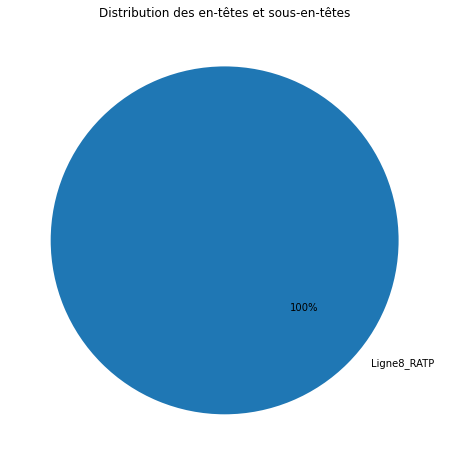

In [23]:
# Visualisation exploratoire

lignes = []  
nb_tweet = []

for ligne in df_annonces_RATP["author_name"].unique():
    lignes.append(ligne) #stocker les 24 lignes de la RATP
    nb_tweet.append(df_annonces_RATP[df_annonces_RATP["author_name"]== ligne]['tweets'].count()) # stocker le nombre de tweets pour chauqe ligne RATP
plt.figure(figsize=(12, 8))   
labels = lignes
tailles = nb_tweet
plt.pie(tailles, labels=labels, autopct = '%1.f%%', counterclock=False, startangle=500)
plt.title("Distribution des en-têtes et sous-en-têtes")
plt.show()

In [24]:
def nettoyage(texte):
    '''
    Une fonction qui permet de nettoyer les tweets.
    '''
    sans_mv = [word.text.lower() for word in nlp(clean(texte, no_emoji=True, no_digits=True, no_urls=True, replace_with_url="", replace_with_digit="")) if word.text.lower() not in mots_vides] #1 supprimer les stopwords + url + digit + emoji
    mot_propre = [element for element in sans_mv if element not in string.punctuation] #2 supprimer les ponctuations
    return mot_propre #3 retouner la liste de mots propres

def racinisation(texte):
    '''
    Cette fonction permet de raciniser le texte nettoyé.
    '''
    return [stemmer.stem(x) for x in nettoyage(texte)]


def chercherCaus(text):
    liste_causes = []
    for phrase in tqdm(text.split(".")): #segmenter tweet en phrase(s)
        for caus in causes_jargon:
            if set(racinisation(caus)).issubset(racinisation(phrase)): #vérifier si cause est dans tweet
                liste_causes.append(caus)
    return liste_causes
            
        
def chercherCons(text):
    liste_consequences = []
    for phrase in text.split("."): #segmenter tweet en phrase(s)
        for cons in consequences_jargon:
            if set(racinisation(cons)).issubset(racinisation(phrase)): #vérifier si conséquence est dans tweet
                liste_consequences.append(cons)
    return liste_consequences

In [27]:
start = time.time()

df_annonces_RATP["causes_si_publi_RATP"] = list(map(chercherCaus, df_annonces_RATP['tweets_1'])) #remplir la colonne cause si jargon trouvé
df_annonces_RATP["consequences_si_publi_RATP"] = list(map(chercherCons, df_annonces_RATP['tweets_1'])) #remplir la colonne conséquence si jargon trouvé


df_annonces_RATP.to_pickle("df_annonces_RATP.pickle") #écrire un fichier pickle pour une utilisation ultèrieure

end = time.time()
print(f"le temps d'exécution: {end - start} secondes")

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


le temps d'exécution: 62.35218095779419 secondes


In [178]:
# charger un dataframe d'en tête et de sous-en-tête avec causes / conséquences identifiées
df_annonces_RATP = pd.read_pickle('df_annonces_RATP.pickle')

# créer un dataframe de conversations (en ligne) et leur cycle incidents causes / conséquences (en colonne)

df_annonces_RATP.sort_values(by = ['time'], inplace = True) # trier le jeu de donnée sur la colonne 'time'

# transformer les listes causes/conséquences de conversation en string
df_annonces_RATP["causes_si_publi_RATP"] = df_annonces_RATP["causes_si_publi_RATP"].agg(lambda x: ', '.join(map(str, x)))
df_annonces_RATP["consequences_si_publi_RATP"] = df_annonces_RATP["consequences_si_publi_RATP"].agg(lambda x: ', '.join(map(str, x)))

df_annonces_RATP["causes_si_publi_RATP"] = df_annonces_RATP["causes_si_publi_RATP"].map(lambda x: None if x=='' else x) #Replacer toutes les valeurs vide par l'element None
df_annonces_RATP["consequences_si_publi_RATP"] = df_annonces_RATP["consequences_si_publi_RATP"].map(lambda x: None if x=='' else x) #Replacer toutes les valeurs vide par l'element None


_convers_list = []
for i in df_annonces_RATP['conversation_id'].unique():
    _convers = pd.DataFrame({'conversation_id': [i] ,
                          'causes_si_publi_RATP': [df_annonces_RATP[df_annonces_RATP['conversation_id']== i]['causes_si_publi_RATP'].to_list()[::1]], #les causes sont classées par l'odre chronologique
                          'consequences_si_publi_RATP': [df_annonces_RATP[df_annonces_RATP['conversation_id']== i]['consequences_si_publi_RATP'].to_list()[::1]]}) #les conséquences sont classées par l'odre chronologique
    _convers_list.append(_convers)                     
                          
df_convers_pertur = pd.concat(_convers_list).reset_index(drop=True)
df_convers_pertur

,conversation_id,causes_si_publi_RATP,consequences_si_publi_RATP
0,1512300664491229190,"[Train en panne, Train en panne, Train en panne, Train en panne, None, Train en panne, None, Train en panne, Train en panne, Train en panne, Train en panne, Train en panne, None, Divers incidents, None]","[Train stationne, Trafic interrompu, Trafic interrompu, Trafic interrompu, Trafic perturbé, La reprise est repoussée, Trafic interrompu, Trafic perturbé, Trafic reprend, Trafic interrompu, None, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Reprise progressive du trafic, Trafic reprend, Train reprend, Trafic perturbé, Trafic rétabli, Trafic perturbé, Retour à un trafic régulier]"


In [175]:
df_annonces_RATP

,id,source,time,tweets,retweet_count,reply_count,like_count,quote_count,tweet_link,language,conversation_id,referenced_type,in_reply_to_tweet_id,in_reply_to_user_id,in_reply_to_user_name,in_quoted_tweet_id,in_quoted_user_id,in_quoted_user_name,media_type,media_url,expanded_url,mention_usernames,mention_ids,mention_count,author_name,author_id,author_created,author_verified,author_description,author_location,author_url,author_followers_count,author_following_count,author_tweet_count,author_listed_count,geo_place_id,geo_name,geo_bbox,retrieved_at,tweets_0,tweets_0_repeat,tweets_1,end_search_point,type,type_real,entry,annonces_RATP,causes_si_publi_RATP,consequences_si_publi_RATP
3649096,1512300664491229190,Alcmeon Account Management,2022-04-08 07:25:50,"⚠️ En raison d'un train en panne, la rame stationne entre Invalides et Concorde sur la #ligne8 #RATP",3,8,6,2,https://twitter.com/user/status/1512300664491229190,fr,1512300664491229190,,,,,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"⚠️ En raison d'un train en panne, la rame stationne entre Invalides et Concorde sur la #ligne8 #RATP",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Train stationne
3642009,1512302161576747013,Alcmeon Account Management,2022-04-08 07:31:47,"❌en raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 07h45.",0,2,1,0,https://twitter.com/user/status/1512302161576747013,fr,1512300664491229190,replied_to,1512300664491229190,807230766,Ligne8_RATP,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"❌en raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 07h45.",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Trafic interrompu
3642008,1512305581897535489,Alcmeon Account Management,2022-04-08 07:45:22,"❌En raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 08h15.",2,1,3,1,https://twitter.com/user/status/1512305581897535489,fr,1512300664491229190,replied_to,1512302161576747013,807230766,Ligne8_RATP,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"❌En raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 08h15.",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Trafic interrompu
3642007,1512308916918566913,Alcmeon Account Management,2022-04-08 07:58:37,"❌En raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde et se retrouve perturbé sur le reste de la #ligne8 #RATP. La reprise est estimée vers 08h15.",0,2,3,2,https://twitter.com/user/status/1512308916918566913,fr,1512300664491229190,replied_to,1512305581897535489,807230766,Ligne8_RATP,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"❌En raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde et se retrouve perturbé 

In [179]:
# supprimer dans ce dataframe conversations celles qui n'ont pas au moins une cause ET une conséquence
# on ne garde que les conversations dont sur tout l'arbre, on repère au moins 1 cause et 1 conséquence

# transformer les listes causes/conséquences de conversation en string

df_convers_pertur['causes_si_publi_RATP'] = df_convers_pertur['causes_si_publi_RATP'].agg(lambda x: ', '.join(map(str, x)))
df_convers_pertur['consequences_si_publi_RATP'] = df_convers_pertur['consequences_si_publi_RATP'].agg(lambda x: ', '.join(map(str, x)))

df_convers_pertur["causes_si_publi_RATP"] = df_convers_pertur["causes_si_publi_RATP"].map(lambda x: 0 if x=='' else x) #Replacer toutes les valeurs vide par l'element 0
df_convers_pertur["consequences_si_publi_RATP"] = df_convers_pertur["consequences_si_publi_RATP"].map(lambda x: 0 if x=='' else x) #Replacer toutes les valeurs vide par l'element 0

# identifier les conversations dont causes/conséquences vides.
#df_convers_pertur = df_convers_pertur.drop( df_convers_pertur[ df_convers_pertur['causes_si_publi_RATP'].str.isnumeric()== True ].index)
#df_convers_pertur_v1 = df_convers_pertur.drop( df_convers_pertur[ df_convers_pertur['consequences_si_publi_RATP'].str.isnumeric()== True ].index)

# garder uniquement les conversations non_vides
cond = ~df_convers_pertur['conversation_id'].isin(df_convers_pertur_v1['conversation_id'])
df_convers_pertur2 = df_convers_pertur.drop(df_convers_pertur[cond].index)
df_convers_pertur2

#df_convers_pertur2.to_pickle('df_convers_pertur2.pickle')

,conversation_id,causes_si_publi_RATP,consequences_si_publi_RATP
0,1512300664491229190,"Train en panne, Train en panne, Train en panne, Train en panne, None, Train en panne, None, Train en panne, Train en panne, Train en panne, Train en panne, Train en panne, None, Divers incidents, None","Train stationne, Trafic interrompu, Trafic interrompu, Trafic interrompu, Trafic perturbé, La reprise est repoussée, Trafic interrompu, Trafic perturbé, Trafic reprend, Trafic interrompu, None, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Reprise progressive du trafic, Trafic reprend, Train reprend, Trafic perturbé, Trafic rétabli, Trafic perturbé, Retour à un trafic régulier"


## 3. Enrichissement du jeu originel. <a class="anchor" id="section_3"></a>

In [ ]:
# charger...
# (i) le jeu de données originel complet
# (ii) celui des annonces RATP (en têtes et sous-en têtes) avec causes / conseq identifiées
# (iii) le dataframe conversation filtré sur les conversations avec au moins une cause ET une conséquence

df = pd.read_pickle('twitter_RATP_2012_to_2022_06_V2_P5.pickle')
df_annonces_RATP = pd.read_pickle('df_annonces_RATP.pickle')
df_convers_pertur2 = pd.read_pickle('df_convers_pertur2.pickle')

In [180]:
# concat (i) et (ii) pour garder (ii) sur les doublons, puis enrichir le tout avec (iii)
# on enrichit donc le jeu de données originel par l'identification causes / conséquences de chaque annonce RATP
# puis on retient officiellement conversations de situations perturbées celles avec au moins une cause une conséquence
# et on détaille leur cycle incident comme métadonnée causes_conversation et consequences_conversation pour chaque tweet de la conversation

df_final = pd.concat([df_annonces_RATP,df]).drop_duplicates(subset='id').reset_index(drop=True)
causes_convers_dict = dict(zip(df_convers_pertur2.conversation_id,df_convers_pertur2.causes_si_publi_RATP))
consequences_convers_dict = dict(zip(df_convers_pertur2.conversation_id,df_convers_pertur2.consequences_si_publi_RATP))

df_final['arbre_conversationnel_perturbation'] = np.where(df_final['conversation_id'].isin(df_convers_pertur2['conversation_id']), True, False)
df_final['causes_conversation'] = df_final['conversation_id'].map(causes_convers_dict)
df_final['consequences_conversation'] = df_final['conversation_id'].map(consequences_convers_dict)

#df_final.to_pickle('df_final_Twitter.pickle')
df_final

,id,source,time,tweets,retweet_count,reply_count,like_count,quote_count,tweet_link,language,conversation_id,referenced_type,in_reply_to_tweet_id,in_reply_to_user_id,in_reply_to_user_name,in_quoted_tweet_id,in_quoted_user_id,in_quoted_user_name,media_type,media_url,expanded_url,mention_usernames,mention_ids,mention_count,author_name,author_id,author_created,author_verified,author_description,author_location,author_url,author_followers_count,author_following_count,author_tweet_count,author_listed_count,geo_place_id,geo_name,geo_bbox,retrieved_at,tweets_0,tweets_0_repeat,tweets_1,end_search_point,type,type_real,entry,annonces_RATP,causes_si_publi_RATP,consequences_si_publi_RATP,arbre_conversationnel_perturbation,causes_conversation,consequences_conversation
0,1512300664491229190,Alcmeon Account Management,2022-04-08 07:25:50,"⚠️ En raison d'un train en panne, la rame stationne entre Invalides et Concorde sur la #ligne8 #RATP",3,8,6,2,https://twitter.com/user/status/1512300664491229190,fr,1512300664491229190,,,,,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"⚠️ En raison d'un train en panne, la rame stationne entre Invalides et Concorde sur la #ligne8 #RATP",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Train stationne,True,"Train en panne, Train en panne, Train en panne, Train en panne, None, Train en panne, None, Train en panne, Train en panne, Train en panne, Train en panne, Train en panne, None, Divers incidents, None","Train stationne, Trafic interrompu, Trafic interrompu, Trafic interrompu, Trafic perturbé, La reprise est repoussée, Trafic interrompu, Trafic perturbé, Trafic reprend, Trafic interrompu, None, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Reprise progressive du trafic, Trafic reprend, Train reprend, Trafic perturbé, Trafic rétabli, Trafic perturbé, Retour à un trafic régulier"
1,1512302161576747013,Alcmeon Account Management,2022-04-08 07:31:47,"❌en raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 07h45.",0,2,1,0,https://twitter.com/user/status/1512302161576747013,fr,1512300664491229190,replied_to,1512300664491229190,807230766,Ligne8_RATP,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"❌en raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 07h45.",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Trafic interrompu,True,"Train en panne, Train en panne, Train en panne, Train en panne, None, Train en panne, None, Train en panne, Train en panne, Train en panne, Train en panne, Train en panne, None, Divers incidents, None","Train stationne, Trafic interrompu, Trafic interrompu, Trafic interrompu, Trafic perturbé, La reprise est repoussée, Trafic interrompu, Trafic perturbé, Trafic reprend, Trafic interrompu, None, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Reprise progressive du trafic, Trafic reprend, Train reprend, Trafic perturbé, Trafic rétabli, Trafic perturbé, Retour à un trafic régulier"
2,1512305581897535489,Alcmeon Account Management,2022-04-08 07:45:22,"❌En raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La re

In [181]:
#supprimer les arbres conversationnels qui n'ont ni cause ni conséquence

df_final_pertu = df_final.drop(df_final[df_final.arbre_conversationnel_perturbation == False].index)
df_final_pertu

,id,source,time,tweets,retweet_count,reply_count,like_count,quote_count,tweet_link,language,conversation_id,referenced_type,in_reply_to_tweet_id,in_reply_to_user_id,in_reply_to_user_name,in_quoted_tweet_id,in_quoted_user_id,in_quoted_user_name,media_type,media_url,expanded_url,mention_usernames,mention_ids,mention_count,author_name,author_id,author_created,author_verified,author_description,author_location,author_url,author_followers_count,author_following_count,author_tweet_count,author_listed_count,geo_place_id,geo_name,geo_bbox,retrieved_at,tweets_0,tweets_0_repeat,tweets_1,end_search_point,type,type_real,entry,annonces_RATP,causes_si_publi_RATP,consequences_si_publi_RATP,arbre_conversationnel_perturbation,causes_conversation,consequences_conversation
0,1512300664491229190,Alcmeon Account Management,2022-04-08 07:25:50,"⚠️ En raison d'un train en panne, la rame stationne entre Invalides et Concorde sur la #ligne8 #RATP",3,8,6,2,https://twitter.com/user/status/1512300664491229190,fr,1512300664491229190,,,,,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"⚠️ En raison d'un train en panne, la rame stationne entre Invalides et Concorde sur la #ligne8 #RATP",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Train stationne,True,"Train en panne, Train en panne, Train en panne, Train en panne, None, Train en panne, None, Train en panne, Train en panne, Train en panne, Train en panne, Train en panne, None, Divers incidents, None","Train stationne, Trafic interrompu, Trafic interrompu, Trafic interrompu, Trafic perturbé, La reprise est repoussée, Trafic interrompu, Trafic perturbé, Trafic reprend, Trafic interrompu, None, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Reprise progressive du trafic, Trafic reprend, Train reprend, Trafic perturbé, Trafic rétabli, Trafic perturbé, Retour à un trafic régulier"
1,1512302161576747013,Alcmeon Account Management,2022-04-08 07:31:47,"❌en raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 07h45.",0,2,1,0,https://twitter.com/user/status/1512302161576747013,fr,1512300664491229190,replied_to,1512300664491229190,807230766,Ligne8_RATP,,,,,,,,,0,Ligne8_RATP,807230766,2012-09-06 19:13:06,True,"Trafic en temps réel, travaux & événements... Retrouvez-nous tous les jours sur votre #ligne8 !\nLa #RATP est opérateur de mobilités pour @idfmobilites.",,https://t.co/nzhu6f8dZX,27020,32,14734,252,,,,2022-09-02 18:19:51,,,"❌en raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La reprise est estimée vers 07h45.",2022-07-01,@Ligne8_RATP,Ligne8RATP,NaN,True,Train en panne,Trafic interrompu,True,"Train en panne, Train en panne, Train en panne, Train en panne, None, Train en panne, None, Train en panne, Train en panne, Train en panne, Train en panne, Train en panne, None, Divers incidents, None","Train stationne, Trafic interrompu, Trafic interrompu, Trafic interrompu, Trafic perturbé, La reprise est repoussée, Trafic interrompu, Trafic perturbé, Trafic reprend, Trafic interrompu, None, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Trafic très perturbé, Trafic interrompu, Trafic perturbé, Reprise progressive du trafic, Trafic reprend, Train reprend, Trafic perturbé, Trafic rétabli, Trafic perturbé, Retour à un trafic régulier"
2,1512305581897535489,Alcmeon Account Management,2022-04-08 07:45:22,"❌En raison d'un train en panne, le trafic est interrompu entre La Motte-Picquet-Grenelle et Concorde sur la #ligne8 #RATP. La re

In [162]:
df_annonces_RATP[ df_annonces_RATP['causes_si_publi_RATP'] ==  ]

,id,source,time,tweets,retweet_count,reply_count,like_count,quote_count,tweet_link,language,conversation_id,referenced_type,in_reply_to_tweet_id,in_reply_to_user_id,in_reply_to_user_name,in_quoted_tweet_id,in_quoted_user_id,in_quoted_user_name,media_type,media_url,expanded_url,mention_usernames,mention_ids,mention_count,author_name,author_id,author_created,author_verified,author_description,author_location,author_url,author_followers_count,author_following_count,author_tweet_count,author_listed_count,geo_place_id,geo_name,geo_bbox,retrieved_at,tweets_0,tweets_0_repeat,tweets_1,end_search_point,type,type_real,entry,annonces_RATP,causes_si_publi_RATP,consequences_si_publi_RATP


In [ ]:
df_final_pertu.to_pickle('twitter_complete_filtered.pickle')